# Vehicle parking Space Detection

## 1. Imports


The code imports various necessary libraries for data handling, image processing, machine learning, and visualization:

In [ ]:
import os
import pickle
import numpy as np
import zipfile
from skimage.io import imread
from skimage.transform import resize, rotate
from skimage.feature import hog
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


## 2. Extracting ZIP Files

This function extracts the contents of a ZIP file to the specified directory. It is used for preparing the dataset.

In [ ]:
# Function to extract ZIP file
def extract_zip(zip_path, extract_to='.'):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)


## 3. Feature Extraction from Images

The function resizes the image to a fixed size (15x15), converts it to grayscale, extracts Histogram of Oriented Gradients (HOG) features, and calculates color statistics (mean and standard deviation). It then combines these features into a single array.

In [ ]:
# Function to extract features from an image
def extract_features(image):
    # Resize image to a fixed size
    image_resized = resize(image, (15, 15))

    # Convert to grayscale
    gray_image = rgb2gray(image_resized)

    # Extract HOG features
    hog_features, _ = hog(
        gray_image,
        orientations=9,
        pixels_per_cell=(4, 4),
        cells_per_block=(2, 2),
        visualize=True
    )

    # Flatten the resized image
    flat_features = image_resized.flatten()

    # Calculate color statistics (mean and standard deviation for each channel)
    color_mean = np.mean(image_resized, axis=(0, 1))
    color_std = np.std(image_resized, axis=(0, 1))

    # Combine all features into a single array
    features = np.hstack([flat_features, hog_features, color_mean, color_std])

    return features

## 4. Data Augmentation with Rotations

This function randomly rotates the input image within the specified angle range. The augmentation increases the diversity of the dataset, helping to reduce overfitting.

In [ ]:
# Function to augment the dataset with random rotations
def augment_image(image, angle_range=(-30, 30)):
    angle = np.random.uniform(angle_range[0], angle_range[1])
    return rotate(image, angle, mode='wrap')

## 5. Data Preparation


This section handles loading and preprocessing the dataset:

It extracts the dataset from a ZIP file.

Iterates over each category ("empty" and "not_empty"), loading images, extracting features, and augmenting the data with randomly rotated images

In [ ]:
# Prepare data
zip_file_path = 'clf-data.zip'
extract_to = 'clf-data'

# Extract the ZIP file
extract_zip(zip_file_path, extract_to)

categories = ['empty', 'not_empty']
data = []
labels = []
get_data = 'clf-data/clf-data'

In [ ]:
# Load and preprocess the data
for category_idx, category in enumerate(categories):
    category_path = os.path.join(get_data, category)
    for file in os.listdir(category_path):
        img_path = os.path.join(category_path, file)
        img = imread(img_path)

        # Original features
        features = extract_features(img)
        data.append(features)
        labels.append(category_idx)

        # Augmented features (rotated images)
        augmented_img = augment_image(img)
        augmented_features = extract_features(augmented_img)
        data.append(augmented_features)
        labels.append(category_idx)

data = np.asarray(data)
labels = np.asarray(labels)

## 6. Dimensionality Reduction Using PCA


Principal Component Analysis (PCA) is applied to reduce the dimensionality of the feature set to 50 components, which can help improve model performance and reduce overfitting.

In [ ]:
# Dimensionality reduction using PCA
pca = PCA(n_components=50)
data = pca.fit_transform(data)

## 7. Splitting Data into Training and Testing Sets

The data is split into training and testing sets, with 80% of the data used for training and 20% for testing. Stratified sampling ensures that both classes are evenly represented.

In [ ]:
# Train / test split
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, shuffle=True, stratify=labels)


## 8. Training the Classifier

In [ ]:
# Train a Decision Tree classifier
decision_tree_classifier = DecisionTreeClassifier()

# Fit the Decision Tree model
decision_tree_classifier.fit(x_train, y_train)


DecisionTreeClassifier()

## 9. Model Evaluation

The trained model is tested on the test set, and the accuracy is calculated.

In [ ]:
# Test performance
y_prediction = best_estimator.predict(x_test)
score = accuracy_score(y_prediction, y_test)
print(f'{score * 100:.2f}% of samples were correctly classified.')


100.00% of samples were correctly classified.


## 10. Plotting the Learning Curve

This function plots the learning curve, showing how the accuracy changes with different training set sizes.

In [ ]:
# Function to plot the accuracy learning curve
def plot_accuracy_curve(estimator, X, y, title="Accuracy Curve"):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(12, 6))
    plt.title(title)
    plt.xlabel("Training Examples")
    plt.ylabel("Accuracy")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Accuracy")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation Accuracy")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

## 11. Training and Testing Accuracy Calculation

Training and testing accuracies are calculated to assess model performance.

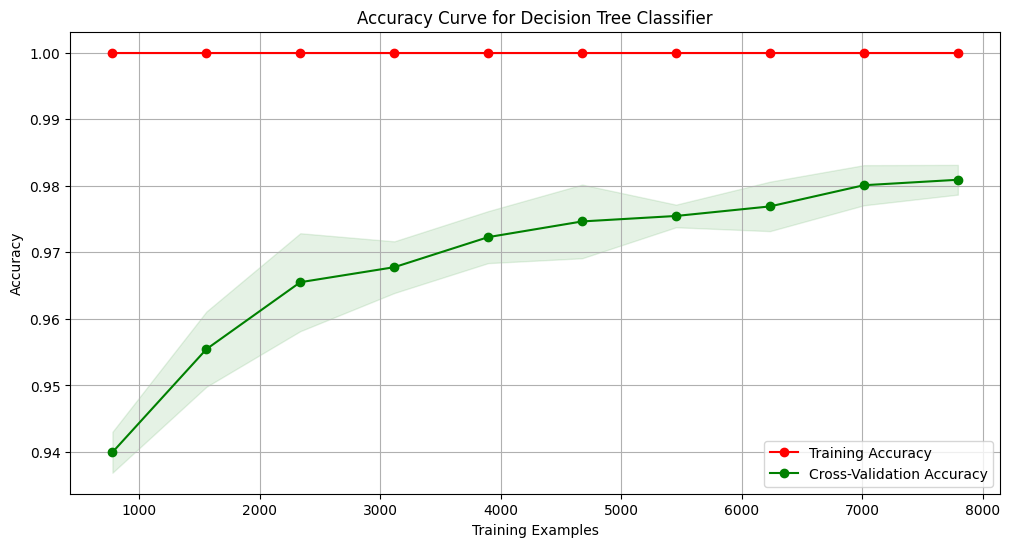

Training Accuracy: 100.00%
Testing Accuracy: 98.52%


In [ ]:
# Plot the accuracy curve for the Decision Tree classifier
plot_accuracy_curve(decision_tree_classifier, x_train, y_train, title="Accuracy Curve for Decision Tree Classifier")

# Calculate training and testing accuracy
train_accuracy = accuracy_score(y_train, decision_tree_classifier.predict(x_train))
test_accuracy = accuracy_score(y_test, decision_tree_classifier.predict(x_test))
print(f'Training Accuracy: {train_accuracy * 100:.2f}%')
print(f'Testing Accuracy: {test_accuracy * 100:.2f}%')

## 12. confusion matrix

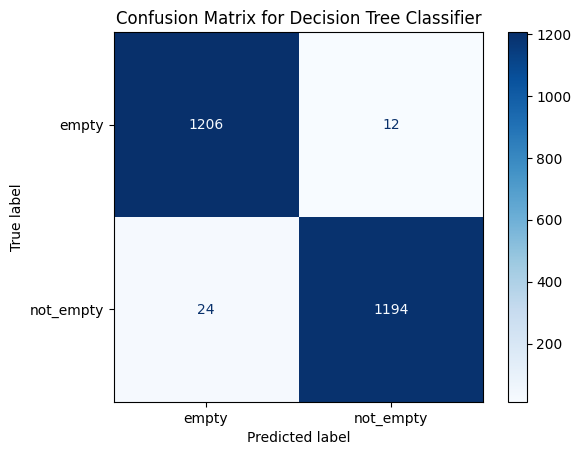

In [ ]:
# Generate predictions on the test set
y_pred = decision_tree_classifier.predict(x_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Decision Tree Classifier')
plt.show()

## 13. Saving the Trained Model

The trained model is saved to a file using pickle for future use.

In [ ]:
# Save the trained model
with open('./model.p', 'wb') as model_file:
    pickle.dump(best_estimator, model_file)

## 14. Making Predictions on New Images

This function loads the trained model, preprocesses a new image, and predicts whether the parking space is "empty" or "not_empty."

In [ ]:
# Function to predict if a given image is 'empty' or 'not_empty' using the enhanced model
def predict_parking_space(image_path, model_path='./CarParkPos'):
    # Load the trained model
    with open(model_path, 'rb') as model_file:
        model = pickle.load(model_file)

    # Read and preprocess the imag4
    img = imread(image_path)
    features = pca.transform([extract_features(img)])  # Extract features and apply PCA

    # Predict using the model
    prediction = model.predict(features)

    # Output result
    result = 'empty' if prediction[0] == 0 else 'free'
    print(f'The parking space is {result}.')
    return result

## 15. Displaying the Input Image

This section displays the input image and uses the trained model to make a prediction.

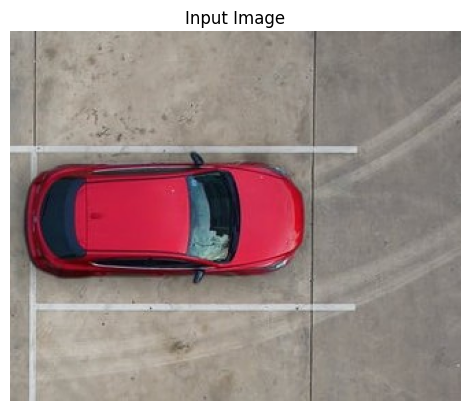

The parking space is empty.


'empty'

In [ ]:
# Load and display the input image
def show_input_image(image_path):
    img = imread(image_path)  # Load the image
    plt.imshow(img)           # Display the image
    plt.title('Input Image')  # Title of the plot
    plt.axis('off')           # Hide axis
    plt.show()

# Example usage
image_path = '/content/8.jpg'
show_input_image(image_path)

predict_parking_space(image_path)